# Sydney Housing Price Prediction

## Olivia Wang
#### Packages: sklearn, matplotlib, seaborn, pandas, numpy
#### Source: https://www.kaggle.com/shree1992/housedata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')
df = df.drop(columns=['date'])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 17 columns):
price            4600 non-null float64
bedrooms         4600 non-null float64
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
sqft_lot         4600 non-null int64
floors           4600 non-null float64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     4600 non-null int64
street           4600 non-null object
city             4600 non-null object
statezip         4600 non-null object
country          4600 non-null object
dtypes: float64(4), int64(9), object(4)
memory usage: 611.1+ KB


### 1.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price.

In [3]:
categorical_var = ['bedrooms','bathrooms','floors','waterfront',
                   'view','condition','street','city','statezip','country']
continuous_var = ['sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built',
                  'yr_renovated']
for col in categorical_var:
    df[col] = df[col].astype('object')
print(f'categorical variables: {categorical_var}')
print(f'continuous variables: {continuous_var}')

categorical variables: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'street', 'city', 'statezip', 'country']
continuous variables: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


In [4]:
# Drop rows without a valid sales price
df = df[df.price != 0]
df.head()
df_features = df.drop(columns=['price', 'street', 'country'])
df_features[['state','zip']] = df_features.statezip.str.split(expand=True) 
df_features = df_features.drop(columns=['statezip'])
df_features.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,state,zip
0,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,WA,98133
1,5,2.5,3650,9050,2,0,4,5,3370,280,1921,0,Seattle,WA,98119
2,3,2,1930,11947,1,0,0,4,1930,0,1966,0,Kent,WA,98042
3,3,2.25,2000,8030,1,0,0,4,1000,1000,1963,0,Bellevue,WA,98008
4,4,2.5,1940,10500,1,0,0,4,1140,800,1976,1992,Redmond,WA,98052


In [5]:
print(df_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4551 entries, 0 to 4599
Data columns (total 15 columns):
bedrooms         4551 non-null object
bathrooms        4551 non-null object
sqft_living      4551 non-null int64
sqft_lot         4551 non-null int64
floors           4551 non-null object
waterfront       4551 non-null object
view             4551 non-null object
condition        4551 non-null object
sqft_above       4551 non-null int64
sqft_basement    4551 non-null int64
yr_built         4551 non-null int64
yr_renovated     4551 non-null int64
city             4551 non-null object
state            4551 non-null object
zip              4551 non-null object
dtypes: int64(6), object(9)
memory usage: 568.9+ KB
None


In [6]:
to_plot = continuous_var
to_plot.append('price')

### 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target. 

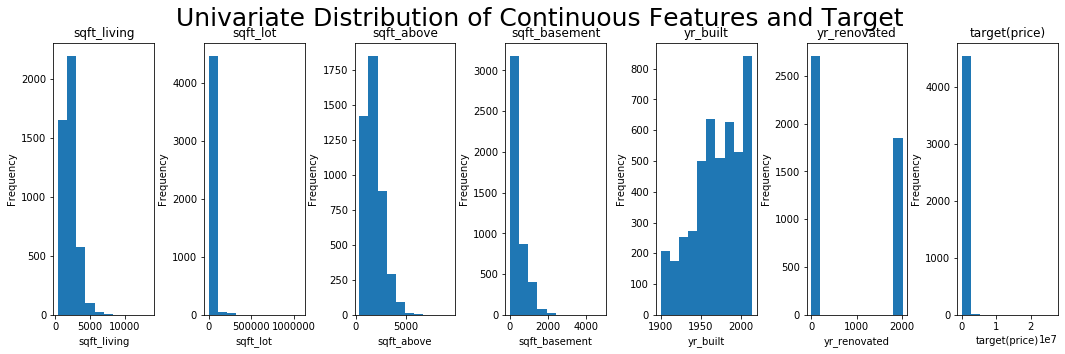

In [7]:
width = 7
fig, ax = plt.subplots(1, width, figsize = (18, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Univariate Distribution of Continuous Features and Target', fontsize = 25)
for i in range(len(ax)):
    ax[i].hist(df[to_plot[i]])
    if to_plot[i] != 'price':
        ax[i].title.set_text(to_plot[i])
        ax[i].set_xlabel(to_plot[i])
        ax[i].set_ylabel('Frequency')
    else:
        ax[i].title.set_text('target(price)')
        ax[i].set_xlabel('target(price)')
        ax[i].set_ylabel('Frequency')

#### It appears that the distribution of most of the continuous features and the target are highly skewed. As a result, scaling maybe helpful. On top of which, it appears that the distribution of year built is concentrated around two values. One can even argue that it is a categorical variable. As a result, it is important to consider what determines if a specific data is continuous or categorical.

### 1.3 Visualize the dependency of the target on each continuous feature (2d scatter plot).

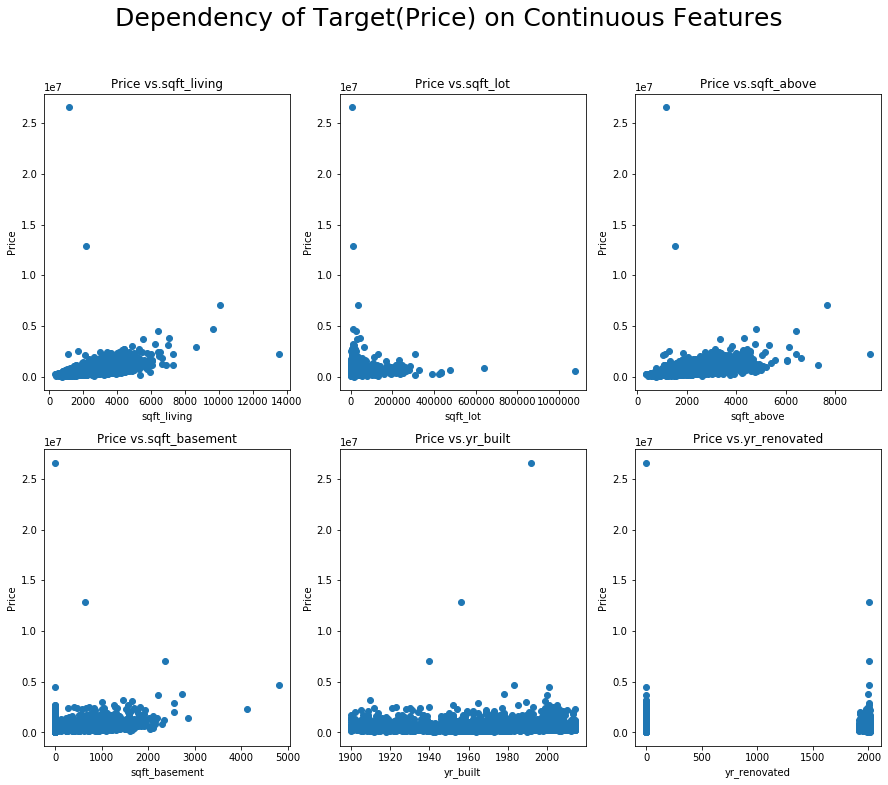

In [8]:
width = 3
fig, ax = plt.subplots(2,width, figsize = (15, 12))
fig.suptitle('Dependency of Target(Price) on Continuous Features', fontsize = 25)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row + column
        ax[row,column].scatter(df[continuous_var[i]], df['price'])
        ax[row,column].title.set_text('Price vs.' + to_plot[i])
        ax[row,column].set_xlabel(to_plot[i])
        ax[row,column].set_ylabel('Price')

### 1.4 Split data in training and test set. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df['price'], random_state=42)

#### Unscaled

In [10]:
# Unscaled
categories = X_train.dtypes == 'object'
preprocess = make_column_transformer(
    (SimpleImputer(strategy='mean'), ~categories),
    (OneHotEncoder(handle_unknown = 'ignore'), categories))

In [11]:
# Linear Regression
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, LinearRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using lr: {scores:0.8f}')

# Ridge
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, Ridge())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using Ridge: {scores:0.8f}')

# Lasso
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, Lasso())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using Lasso: {scores:0.8f}')

# ElasticNet
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, ElasticNet())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using ElasticNet: {scores:0.8f}')

mean cv accuracy using lr: 0.47344818
mean cv accuracy using Ridge: 0.34337640
mean cv accuracy using Lasso: 0.47230860
mean cv accuracy using ElasticNet: 0.37032179


#### Scaled

In [12]:
# With StandardScaler()
categories = X_train.dtypes == 'object'
preprocess = make_column_transformer(
    (SimpleImputer(strategy='mean'), ~categories),
    (StandardScaler(), ~categories),
    (OneHotEncoder(handle_unknown = 'ignore'), categories))

In [13]:
# Linear Regression
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, LinearRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using lr: {scores:0.8f}')

# Ridge
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, Ridge())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using Ridge: {scores:0.8f}')

# Lasso
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, Lasso())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using Lasso: {scores:0.8f}')

# ElasticNet
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, ElasticNet())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using ElasticNet: {scores:0.8f}')

mean cv accuracy using lr: 0.47357749
mean cv accuracy using Ridge: 0.34337635
mean cv accuracy using Lasso: 0.47230869
mean cv accuracy using ElasticNet: 0.37032179


#### Does scaling the data with StandardScaler help? 

#### Whereas we previously proposed that scaling the data would help, we can see that scaling the data did not influence the cross-validation accuracy much. It may have improved very slightly, but that is trivial given the randomness in our sampling.

### 1.5 Tune the parameters of the models using GridSearchCV. 

In [14]:
pipe = Pipeline([('scaler', preprocess),
                 ('regressor', LinearRegression())])

param_grid = [{'regressor': [Ridge()],
               'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
              {'regressor': [Lasso()],
               'regressor__alpha': [0.3, 0.5, 0.7, .9, 1]},
              {'regressor': [ElasticNet()],
               'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
               'regressor__l1_ratio': [0.3, 0.5, 0.7, .9, 1]}
             ]
grid = GridSearchCV(pipe, param_grid, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])

0.7089978340113741
{'regressor': ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.7,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.7}
[0.34337635 0.34337635 0.34337635 0.34337635 0.34337635 0.47228582
 0.47229741 0.47230714 0.4723163  0.47232436 0.47331228 0.47305734
 0.47277722 0.47246232 0.47227168 0.47703952 0.47630165 0.47527446
 0.47365683 0.47227167 0.47424604 0.47699702 0.47883809 0.47782325
 0.47227173 0.42138956 0.43126666 0.44568633 0.46969382 0.47227497
 0.3643624  0.37032184 0.38130791 0.41090097 0.47232436]


In [15]:
pipe = Pipeline([('scaler', preprocess),
                 ('regressor', LinearRegression())])

param_grid = [{'regressor': [ElasticNet()],
               'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
             ]

grid = GridSearchCV(pipe, param_grid, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])
results_grid_a = pd.DataFrame.from_dict(grid.cv_results_)

{'regressor': ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 'regressor__alpha': 0.01}
[0.47305734 0.47630165 0.47699702 0.43126666 0.37032184]


In [16]:
results_grid_a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.096144,0.015760,0.007760,0.000268,"ElasticNet(alpha=0.01, copy_X=True, fit_interc...",0.0001,"{'regressor': ElasticNet(alpha=0.01, copy_X=Tr...",0.035441,0.307206,0.654762,...,0.473057,0.263707,3,0.586818,0.272055,0.255645,0.240879,0.250344,0.321148,0.133220
1,1.163806,0.043048,0.009142,0.000720,"ElasticNet(alpha=0.01, copy_X=True, fit_interc...",0.001,"{'regressor': ElasticNet(alpha=0.01, copy_X=Tr...",0.036132,0.306440,0.660346,...,0.476302,0.265897,2,0.585514,0.271566,0.255033,0.240251,0.249894,0.320452,0.132920
2,1.183384,0.033554,0.008107,0.000527,"ElasticNet(alpha=0.01, copy_X=True, fit_interc...",0.01,"{'regressor': ElasticNet(alpha=0.01, copy_X=Tr...",0.036986,0.296631,0.663586,...,0.476997,0.268090,1,0.568502,0.263320,0.246943,0.231039,0.241997,0.310360,0.129489
3,1.200037,0.073533,0.009664,0.002147,"ElasticNet(alpha=0.01, copy_X=True, fit_interc...",0.1,"{'regressor': ElasticNet(alpha=0.01, copy_X=Tr...",0.032132,0.262961,0.600071,...,0.431267,0.243592,4,0.489309,0.222508,0.207238,0.189987,0.203453,0.262499,0.113878
4,1.272502,0.086516,0.011303,0.003579,"ElasticNet(alpha=0.01, copy_X=True, fit_interc...",1,"{'regressor': ElasticNet(alpha=0.01, copy_X=Tr...",0.023868,0.227506,0.505280,...,0.370322,0.210449,5,0.408715,0.178411,0.167080,0.148538,0.164239,0.213397,0.098124


In [17]:
pipe = Pipeline([('scaler', preprocess),
                 ('regressor', LinearRegression())])
param_grid = [{'regressor': [Ridge()],
               'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
              {'regressor': [Lasso()],
               'regressor__alpha': [0.3, 0.5, 0.7, .9, 1]},
              {'regressor': [ElasticNet(alpha = 0.01)],
               'regressor__l1_ratio': [0.3, 0.5, 0.7, .9, 1]}
             ]
grid = GridSearchCV(pipe, param_grid, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])
results_grid_all = pd.DataFrame.from_dict(grid.cv_results_)

0.7089978340113741
{'regressor': ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.7,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 'regressor__l1_ratio': 0.7}
[0.34337635 0.34337635 0.34337635 0.34337635 0.34337635 0.47228582
 0.47229741 0.47230714 0.4723163  0.47232436 0.47424604 0.47699702
 0.47883809 0.47782325 0.47227173]


In [18]:
results_grid_all

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.025033,0.004303,0.012588,0.007293,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.0001,NaN,"{'regressor': Ridge(alpha=1.0, copy_X=True, fi...",0.019877,0.211965,...,0.343376,0.196187,12,0.376474,0.161217,0.151325,0.133148,0.148386,0.194110,0.091625
1,0.022380,0.002332,0.008591,0.000941,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.001,NaN,"{'regressor': Ridge(alpha=1.0, copy_X=True, fi...",0.019877,0.211965,...,0.343376,0.196187,11,0.376474,0.161217,0.151325,0.133148,0.148386,0.194110,0.091625
2,0.019407,0.000093,0.007767,0.000826,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.01,NaN,"{'regressor': Ridge(alpha=1.0, copy_X=True, fi...",0.019877,0.211965,...,0.343376,0.196187,13,0.376474,0.161217,0.151325,0.133148,0.148386,0.194110,0.091625
3,0.021673,0.001227,0.008200,0.000224,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.1,NaN,"{'regressor': Ridge(alpha=1.0, copy_X=True, fi...",0.019877,0.211965,...,0.343376,0.196187,14,0.376474,0.161217,0.151325,0.133148,0.148386,0.194110,0.091625
4,0.021422,0.002123,0.008365,0.001342,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",1,NaN,"{'regressor': Ridge(alpha=1.0, copy_X=True, fi...",0.019877,0.211965,...,0.343376,0.196187,15,0.376474,0.161217,0.151325,0.133148,0.148386,0.194110,0.091625
5,1.090643,0.013507,0.007517,0.000101,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.3,NaN,"{'regressor': Lasso(alpha=1.0, copy_X=True, fi...",0.035293,0.307161,...,0.472286,0.263208,9,0.586856,0.272067,0.255662,0.240896,0.250355,0.321167,0.133229
6,1.142681,0.026821,0.008188,0.000700,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.5,NaN,"{'regressor': Lasso(alpha=1.0, copy_X=True, fi...",0.035295,0.307156,...,0.472297,0.263219,8,0.586856,0.272067,0.255662,0.240896,0.250355,0.321167,0.133229
7,1.063543,0.005115,0.007831,0.000550,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.7,NaN,"{'regressor': Lasso(alpha=1.0, copy_X=True, fi...",0.035295,0.307154,...,0.472307,0.263229,7,0.586856,0.272067,0.255662,0.240896,0.250355,0.321167,0.133229
8,1.142105,0.081477,0.012205,0.008045,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.9,NaN,"{'regressor': Lasso(alpha=1.0, copy_X=True, fi...",0.035295,0.307149,...,0.472316,0.263238,6,0.586856,0.272067,0.255662,0.240896,0.250355,0.321167,0.133229
9,1.030413,0.020512,0.007496,0.000101,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",1,NaN,"{'regressor': Lasso(alpha=1.0, copy_X=True, fi...",0.035295,0.307146,...,0.472324,0.263246,5,0.586856,0.272067,0.255662,0.240896,0.250355,0.321167,0.133229


#### We can see that tuning the parameters using GridSearchCV improved the cross validation accuracy drastically by comparing the test scores using GridSearchCV to the accuracy scores obtained without using parameter tuning.

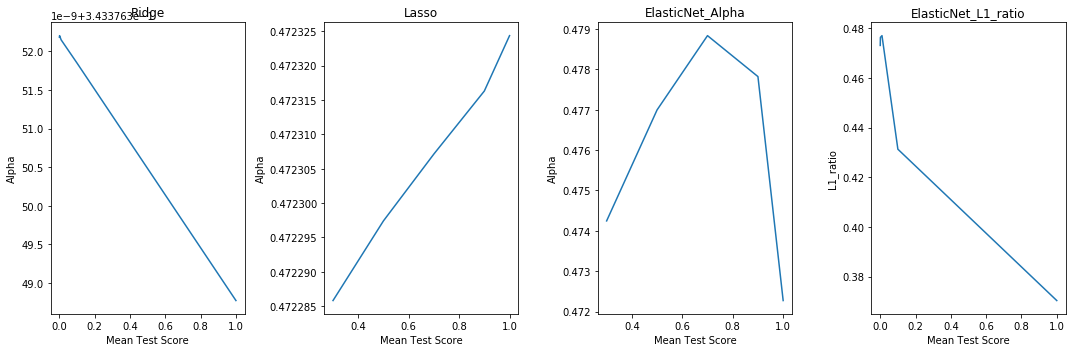

In [26]:
fig, ax = plt.subplots(1,4, figsize = (15, 5))
fig.subplots_adjust(hspace=1.5)
ax[0].plot([0.0001, 0.001, 0.01, 0.1, 1], 'mean_test_score', data = results_grid_all[0:5])
ax[0].title.set_text('Ridge')
ax[0].set_xlabel('Mean Test Score')
ax[0].set_ylabel('Alpha')
ax[1].plot([0.3, 0.5, 0.7, .9, 1], 'mean_test_score', data = results_grid_all[5:10])
ax[1].title.set_text('Lasso')
ax[1].set_xlabel('Mean Test Score')
ax[1].set_ylabel('Alpha')
ax[2].plot([0.3, 0.5, 0.7, .9, 1], 'mean_test_score', data = results_grid_all[10:])
ax[2].title.set_text('ElasticNet_Alpha')
ax[2].set_xlabel('Mean Test Score')
ax[2].set_ylabel('Alpha')
ax[3].plot([0.0001, 0.001, 0.01, 0.1, 1], 'mean_test_score', data = results_grid_a )
ax[3].title.set_text('ElasticNet_L1_ratio')
ax[3].set_xlabel('Mean Test Score')
ax[3].set_ylabel('L1_ratio')
plt.tight_layout()
plt.show()

### 1.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which features are important?

In [20]:
pipe_r = Pipeline([("Preprocessor", preprocess),
                   ("scaler", Ridge(alpha = 0.01))]).fit(X_train, y_train)
model_r = pipe_r[-1].coef_
best_coeff_r = np.argpartition(abs(model_r), -20)[-20:]
print(best_coeff_r)

[ 15  63  75 108  46  14  60  64  61  92  30  16  52  59   3   4  10  95
   2   0]


Text(0.5, 0, 'Column Index')

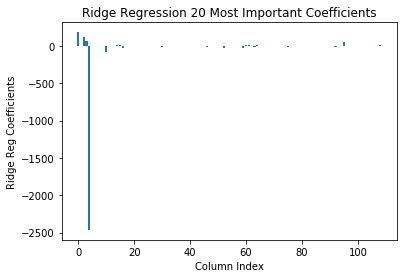

In [21]:
ax = plt.bar(best_coeff_r, model_r[best_coeff_r])
plt.title('Ridge Regression 20 Most Important Coefficients')
plt.ylabel('Ridge Reg Coefficients')
plt.xlabel('Column Index')

In [22]:
pipe_l = Pipeline([("Preprocessor", preprocess),
                   ("scaler",Lasso(alpha = 1))]).fit(X_train, y_train)
model_l = pipe_l[-1].coef_
best_coeff_l = np.argpartition(abs(model_l), -20)[-20:]
print(best_coeff_l)

[177  73 151 101  38  83 103  82  50 163  43 108  21  39 158 157 178 179
 124 153]


Text(0.5, 0, 'Column Index')

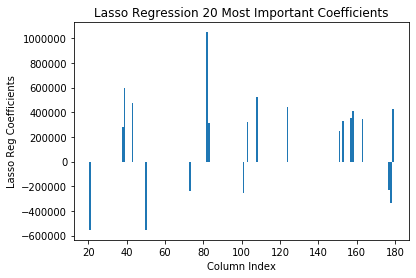

In [23]:
ax = plt.bar(best_coeff_l, model_l[best_coeff_l])
plt.title('Lasso Regression 20 Most Important Coefficients')
plt.ylabel('Lasso Reg Coefficients')
plt.xlabel('Column Index')

In [24]:
pipe_e = Pipeline([("Preprocessor", preprocess),
                   ("scaler", ElasticNet(alpha = 0.01, l1_ratio = 0.7))]).fit(X_train, y_train)
model_e = pipe_e[-1].coef_
best_coeff_e = np.argpartition(abs(model_e), -20)[-20:]
print(best_coeff_e)

[ 38 163  64 158 157 130 154  51 153  50  82  83  95 108 176  39 124 179
 131 129]


Text(0.5, 0, 'Column Index')

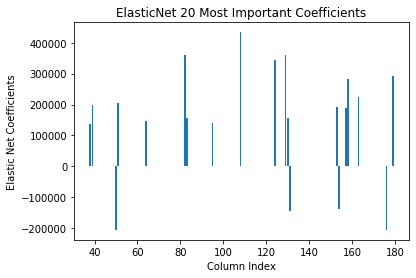

In [25]:
ax = plt.bar(best_coeff_e, model_e[best_coeff_e])
plt.title('ElasticNet 20 Most Important Coefficients')
plt.ylabel('Elastic Net Coefficients')
plt.xlabel('Column Index')

#### From the distributions above, we can see that the models differed on which features are important. Ridge Regression seemed highly skewed in its evaluation of features whereas Lasso and ElasticNet seem more evenly spread out.